## Vision Fine-tuning on GPT-4.1 for Visual Question Answering

In [101]:
# Standard library imports
import json
import os
import random
import time
from io import BytesIO
from pathlib import Path

# Third-party imports
import pandas as pd
import requests
from PIL import Image

# Local imports
from system_prompt import get_system_prompt

from datasets import load_dataset

# load dataset from local cache
cache_dir = os.path.join('cached_datasets')
ds = load_dataset("howard-hou/OCR-VQA", cache_dir=cache_dir)

In [102]:
# Print dataset splits and basic statistics
print(f"Dataset splits: {list(ds.keys())}")

# Print statistics for each split
for split in ds.keys():
    print(f"\n{split} split statistics:")
    print(f"Number of records: {len(ds[split])}")
    print(f"Features: {list(ds[split].features.keys())}")
    
    # Print sample record
    print(f"\nSample record from {split} split:")
    record = ds[split][0]
    print("Image ID:", record['image_id'])
    print("Question:", record['questions'][0])
    print("Answer:", record['answers'][0])
    print("OCR tokens:", record['ocr_tokens'])  
    print("Title:", record['title'])
    print("Author:", record['authorName'])
    print("Genre:", record['genre'])
    print("-" * 50)

Dataset splits: ['train', 'validation', 'test']

train split statistics:
Number of records: 166022
Features: ['image', 'image_id', 'questions', 'answers', 'ocr_tokens', 'ocr_info', 'title', 'authorName', 'genre', 'image_width', 'image_height', 'image_url', 'set_name']

Sample record from train split:
Image ID: 000195850X
Question: Who wrote this book?
Answer: David MACAULAY
OCR tokens: ['under', 'ground', 'david', 'macaulay']
Title: Underground
Author: David MACAULAY
Genre: Children's Books
--------------------------------------------------

validation split statistics:
Number of records: 20731
Features: ['image', 'image_id', 'questions', 'answers', 'ocr_tokens', 'ocr_info', 'title', 'authorName', 'genre', 'image_width', 'image_height', 'image_url', 'set_name']

Sample record from validation split:
Image ID: 000638692X
Question: Who wrote this book?
Answer: Philip Marsden
OCR tokens: ['the', 'bronskihouse', 'philip', 'mar', 'sden']
Title: The Bronski House: A Return to the Borderlands


We'll begin by sampling 150 training examples, 50 validation examples and 100 test examples. We will also explode the questions and answers columns to create a single QA pair for each row. Additionally, since our images are stored as byte strings, we'll convert them to images for processing.

In [ ]:
import pandas as pd
from io import BytesIO
from PIL import Image

# sample 150 training examples, 50 validation examples and 100 test examples
ds_train = ds['train'].shuffle(seed=42).select(range(10))
ds_val = ds['validation'].shuffle(seed=42).select(range(5))
ds_test = ds['test'].shuffle(seed=42).select(range(10))

# convert to pandas dataframe
ds_train = ds_train.to_pandas()
ds_val = ds_val.to_pandas()
ds_test = ds_test.to_pandas()

# convert byte strings to images
ds_train['image'] = ds_train['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_val['image'] = ds_val['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_test['image'] = ds_test['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))

# explode the 'questions' and 'answers' columns
ds_train = ds_train.explode(['questions', 'answers'])
ds_val = ds_val.explode(['questions', 'answers'])
ds_test = ds_test.explode(['questions', 'answers'])

# rename columns
ds_train = ds_train.rename(columns={'questions': 'question', 'answers': 'answer'})
ds_val = ds_val.rename(columns={'questions': 'question', 'answers': 'answer'})
ds_test = ds_test.rename(columns={'questions': 'question', 'answers': 'answer'})

# create unique ids for each example
ds_train = ds_train.reset_index(drop=True)
ds_val = ds_val.reset_index(drop=True)
ds_test = ds_test.reset_index(drop=True)

# select columns
ds_train = ds_train[['question', 'answer', 'image']]
ds_val = ds_val[['question', 'answer', 'image']]
ds_test = ds_test[['question', 'answer', 'image']]

# Print dataset statistics
print("Training Dataset Stats:")
print(f"Number of examples: {len(ds_train)}")
print(f"Number of unique questions: {ds_train['question'].nunique()}")
print(f"Number of unique answers: {ds_train['answer'].nunique()}")
print("\nValidation Dataset Stats:")
print(f"Number of examples: {len(ds_val)}")
print(f"Number of unique questions: {ds_val['question'].nunique()}")
print(f"Number of unique answers: {ds_val['answer'].nunique()}")
print("\nTest Dataset Stats:")
print(f"Number of examples: {len(ds_test)}")
print(f"Number of unique questions: {ds_test['question'].nunique()}")
print(f"Number of unique answers: {ds_test['answer'].nunique()}")


In [ ]:
from IPython.display import display

# display a random training example
print('QUESTION:', ds_train.iloc[1]['question'])
display(ds_train.iloc[1]['image'])
print('ANSWER:', ds_train.iloc[1]['answer'])

#### Data Preparation ####
To ensure successful fine-tuning of our model, it’s crucial to properly structure the training data. Correctly formatting the data helps avoid validation errors during training and ensures the model can effectively learn from both text and image inputs. The good news is, this process is quite straightforward.

Each example in the training dataset should be a conversation in the same format as the Chat Completions API. Specifically, this means structuring the data as a series of messages, where each message includes a role (such as "user" or "assistant") and the content of the message.

Since we are working with both text and images for vision fine-tuning, we’ll construct these messages to include both content types. For each training sample, the question about the image is presented as a user message, and the corresponding answer is provided as an assistant message.

Images can be included in one of two ways:

- As HTTP URLs, referencing the location of the image.
- As data URLs containing the image encoded in base64.

Here’s an example of how the message format should look:

In [ ]:
{
    "messages": 
    [
        {
            "role": "system",
            "content": "Use the image to answer the question."
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What is the title of this book?"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,<encoded_image>"}}
            ]
        }
    ]
}

Let's start by defining the *system instructions* for our model. These instructions provide the model with important context, guiding how it should behave when processing the training data. Clear and concise system instructions are particularly useful to make sure the model reasons well on both text and images.

In [107]:
SYSTEM_PROMPT = """
Generate an answer to the question based on the image of the book provided.
Questions will include both open-ended questions and binary "yes/no" questions.
The questions will inquire about the title, author, edition, year and genre of the book in the image.

You will read the question and examine the corresponding image to provide an accurate answer.

# Steps

1. **Read the Question:** Carefully analyze the question to understand what information is being asked.
2. **Examine the Image:**
   - **Identify Relevant Bounding Boxes (if applicable):** For questions requiring specific details like the title or author, focus on the relevant areas or bounding boxes within the image to extract the necessary text. There may be multiple relevant bounding boxes in the image, so be sure to consider all relevant areas.
   - **Analyze the Whole Image:** For questions that need general reasoning (e.g., "Is this book related to Children's Books?"), consider the entire image, including title, graphics, colors, and overall design elements.
3. **Formulate a Reasoned Answer:**
   - For binary questions (yes/no), use evidence from the image to support your answer.
   - For open-ended questions, provide the exact text from the image or a concise phrase that best describes the requested information.

# Output Format

- Provide your answer in a concise and clear manner. Always return the final conclusion only, no additional text or reasoning.
- If the question is binary, answer with "Yes" or "No."
- For open-ended questions requesting specific details (e.g., title, author), return the exact text from the image.
- For questions about general attributes like "genre," return a single word or phrase that best describes it.

# Notes

- Always prioritize accuracy and clarity in your responses.
- If multiple authors are listed, return the first author listed.
- If the information is not present in the image, try to reason about the question using the information you can gather from the image e.g. if the author is not listed, use the title and genre to find the author.
- Ensure reasoning steps logically lead to the conclusions before stating your final answer.

# Examples
You will be provided with examples of questions and corresponding images of book covers, along with the reasoning and conclusion for each example. Use these examples to guide your reasoning process."""

To ensure our images are properly formatted for vision fine-tuning, they must be in base64 format and either RGB or RGBA. This ensures the model can accurately process the images during training. Below is a function that handles the encoding of images, while also converting them to the correct format if necessary.

This function allows us to control the quality of the image encoding, which can be useful if we want to reduce the size of the file. 100 is the highest quality, and 1 is the lowest. The maximum file size for a fine-tuning job is 1GB, but we are unlikely to see improvements with a very large amount of training data. Nevertheless, we can use the quality parameter to reduce the size of the file if needed to accomodate file size limits.

In [108]:
import base64

def encode_image(image, quality=100):
    if image.mode != 'RGB':
        image = image.convert('RGB')  # Convert to RGB
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality) 
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

We will also include Few-Shot examples from the training set as user and assistant messages to help guide the model's reasoning process.

In [109]:
FEW_SHOT_EXAMPLES = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 1:**\n\n**Question:** Who wrote this book?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[1]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Reasoning:** The cover clearly displays two authors' names, 'Evelyn M. Thomson' and 'Orlen N. Johnson,' at the bottom of the cover, with Evelyn M. Thomson listed first. Typically, the first-listed author is considered the primary author or main contributor.\n\n**Conclusion:** Evelyn Thomson"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 2:**\n\n**Question:** What is the title of this book?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[1]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The cover prominently displays the title across the top and center of the image. The full title reads, 'Computer Systems: An Integrated Approach to Architecture and Operating Systems,' with each component of the title clearly separated and formatted to stand out.\n\n**Conclusion:** Computer Systems: An Integrated Approach to Architecture and Operating Systems"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 3:**\n\n**Question:** Is this book related to Children's Books?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[3]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The cover illustration features a whimsical mermaid holding a red shoe, with gentle, child-friendly artwork that suggests it is targeted toward a young audience. Additionally, the style and imagery are typical of children's literature.\n\n**Conclusion:** Yes"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 4:**\n\n**Question:** Is this book related to History?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[4]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The title 'Oliver Wendell Holmes, Jr.: Civil War Soldier, Supreme Court Justice' clearly indicates that this book focuses on the life of Oliver Wendell Holmes, Jr., providing a biographical account rather than a general historical analysis. Although it references historical elements (Civil War, Supreme Court), the primary focus is on the individual rather than historical events as a whole.\n\n**Conclusion:** No"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 5:**\n\n**Question:** What is the genre of this book?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[5]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The cover prominently features an image of a train station and the title 'Railway Depots, Stations & Terminals,' which directly suggests a focus on railway infrastructure. This points to the book being related to topics within Engineering & Transportation.\n\n**Conclusion:** Engineering & Transportation"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 6:**\n\n**Question:** What type of book is this?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[6]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The title 'Principles and Practice of Modern Chromatographic Methods' suggests a focus on chromatography, a scientific technique used in chemistry and biology. This aligns with the academic and technical nature typical of books in the 'Science & Math' category.\n\n**Conclusion:** Science & Math"}
        ]
    }
]

Now that we have our system instructions, few-shot examples, and the image encoding function in place, the next step is to iterate through the training set and construct the messages required for fine-tuning. As a reminder, each training example must be formatted as a conversation and must include both the image (in base64 format) and the corresponding question and answer.

To fine-tune GPT-4.1, we recommend providing at least 10 examples, but you’ll typically see noticeable improvements with 50 to 100 training examples. In this case, we'll go all-in and fine-tune the model using our larger training sample of 150 images, and 721 QA pairs.

## Constructing the training set

In [111]:
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import json

# One‑time load of the OpenCV Haar cascade
FACE_DET = cv2.CascadeClassifier(cv2.data.haarcascades +
                                 "haarcascade_frontalface_default.xml")

def detect_faces(pil_img, min_size=(40, 40)):
    """Return a list of face bboxes [[x,y,w,h], …] in a PIL image."""
    gray = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2GRAY)
    faces = FACE_DET.detectMultiScale(gray,
                                      scaleFactor=1.1,
                                      minNeighbors=5,
                                      minSize=min_size)
    return faces

def blur_faces(pil_img, faces):
    """Blur each face in‑place and return the modified PIL image."""
    img = np.array(pil_img)
    for (x, y, w, h) in faces:
        roi = img[y:y+h, x:x+w]
        roi = cv2.GaussianBlur(roi, (25, 25), 30)
        img[y:y+h, x:x+w] = roi
    return Image.fromarray(img)



json_data = []

for idx, example in tqdm(ds_train.iterrows()):
    # 1) Load the raw PIL image (your dataset already has it)
    pil_img = example["image"]                 # <- PIL.Image
    faces = detect_faces(pil_img)

    # 2) ***SKIP*** anything with a face:  skip anything that contains at least one face
    if len(faces) > 0:          #  ← FIXED
        continue
    #    ── or, blur & keep:
    # pil_img = blur_faces(pil_img, faces)

    # 3) Encode (your helper)
    img64 = encode_image(pil_img, quality=50)

    # 4) Build the conversation
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    user_message = {
        "role": "user",
        "content": [
            {"type": "text",
             "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{img64}"}}
        ]
    }
    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    convo = [system_message] + FEW_SHOT_EXAMPLES + \
            [user_message, assistant_message]

    json_data.append({"messages": convo})   # ← **you forgot this line**

# 5) Persist
# save the JSON data to a file
with open("ocr-vqa-train.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

print(f"Kept {len(json_data)} clean examples " +
      f"(skipped {len(ds_train) - len(json_data)})")



0it [00:00, ?it/s]

49it [00:01, 36.38it/s]

Kept 38 clean examples (skipped 11)



Structure of all_messages:
[
  {
    "role": "system",
    "content": [
      {
        "type": "text",
        "text": "\nGenerate an answer to the question based on the image of the book provided.\nQuestions will include both open-ended questions and binary \"yes/no\" questions.\nThe questions will inquire about the title, author, edition, year and genre of the book in the image.\n\nYou will read the question and examine the corresponding image to provide an accurate answer.\n\n# Steps\n\n1. **Read the Question:** Carefully analyze the question to understand what information is being asked.\n2. **Examine the Image:**\n   - **Identify Relevant Bounding Boxes (if applicable):** For questions requiring specific details like the title or author, focus on the relevant areas or bounding boxes within the image to extract the necessary text. There may be multiple relevant bounding boxes in the image, so be sure to consider all relevant areas.\n   - **Analyze the Whole Image:** For questions
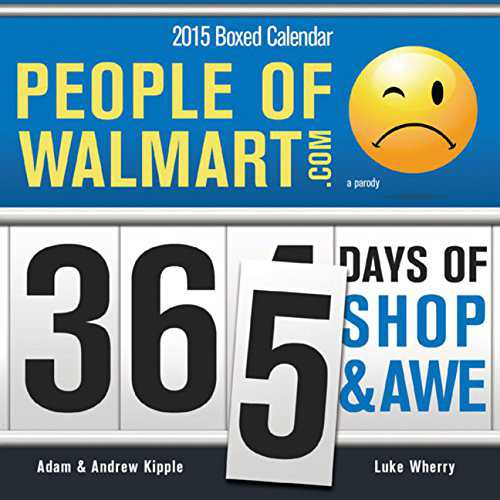
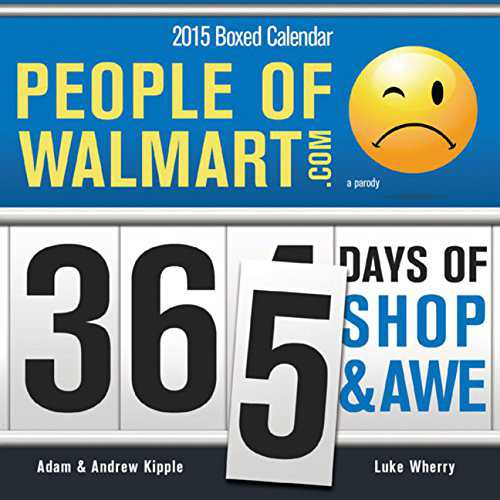
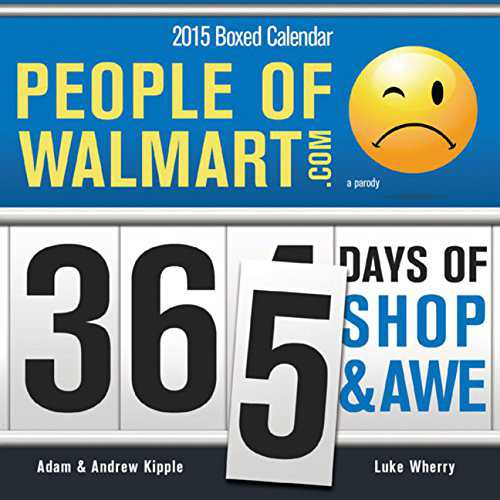
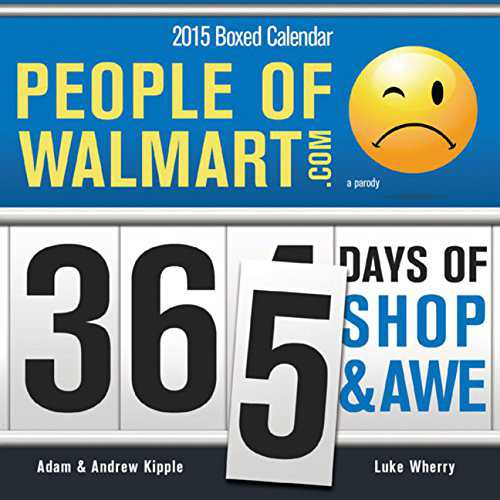
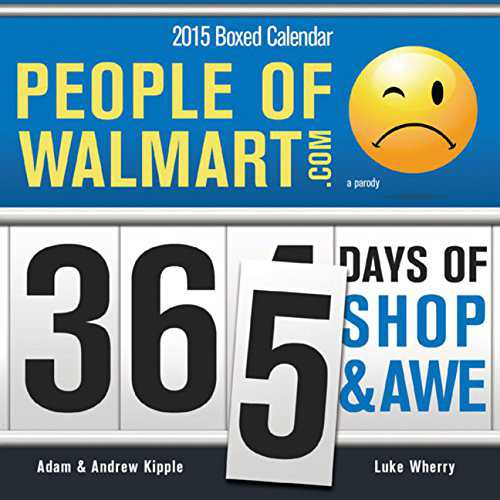
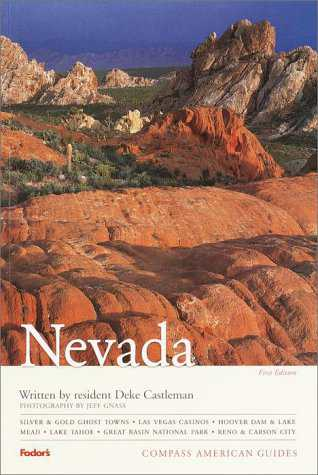
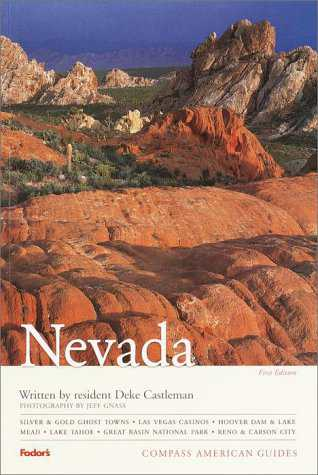
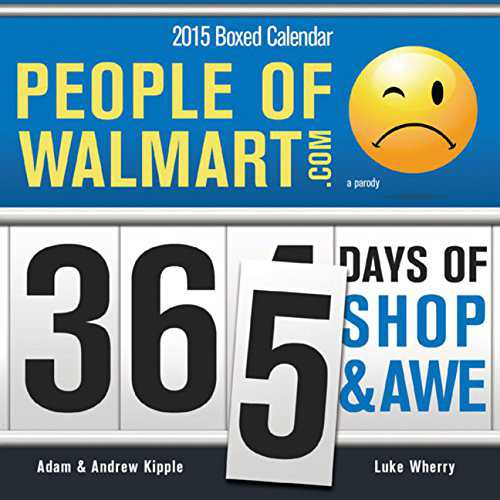
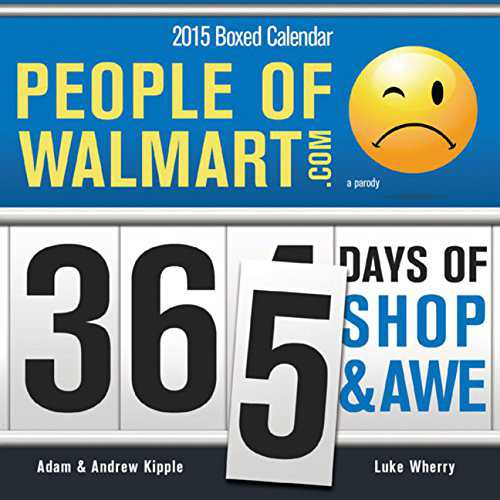
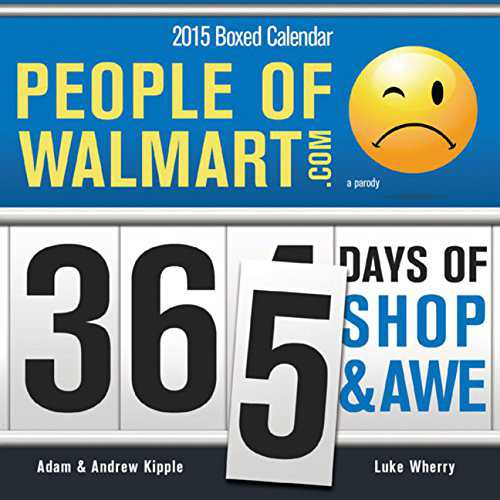
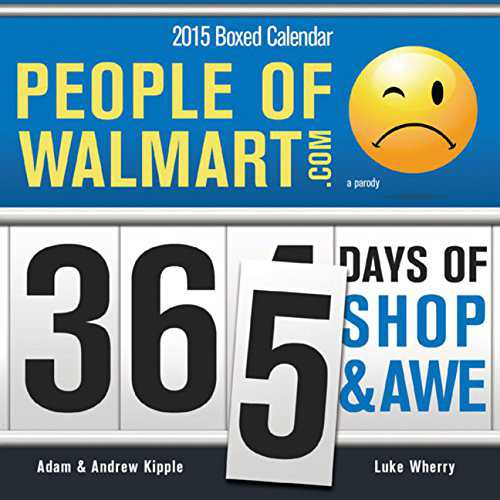
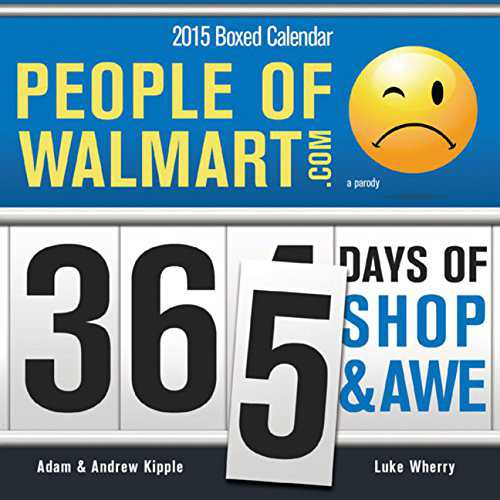
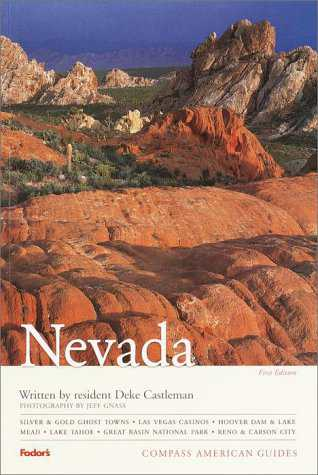
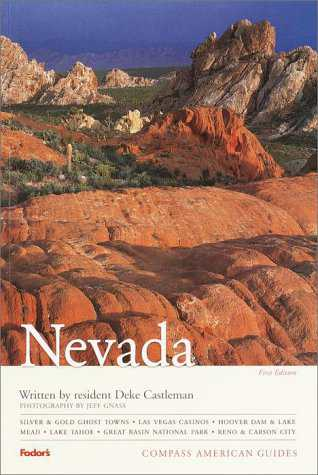

In [112]:
# Let's examine the structure of all_messages and look at one record
print("\nStructure of all_messages:")
print(json.dumps(json_data[0]["messages"], indent=2))

print("\nFirst record:")
print(json.dumps(json_data[0], indent=2))


Just like the training set, we need to structure our validation and test sets in the same message format. However, for the test set, there's a key difference: since the test set is used for evaluation, we do not include the assistant's message (i.e., the answer). This ensures the model generates its own answers, which we can later compare to the ground truth for performance evaluation.

## Constructing the validation set

In [113]:
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import json

# ---------- helpers (same as training) ----------
FACE_DET = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_faces(pil_img, min_size=(40, 40)):
    gray  = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2GRAY)
    faces = FACE_DET.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=min_size)
    return faces

def blur_faces(pil_img, faces):
    img = np.array(pil_img)
    for x, y, w, h in faces:
        roi = img[y:y+h, x:x+w]
        roi = cv2.GaussianBlur(roi, (25, 25), 30)
        img[y:y+h, x:x+w] = roi
    return Image.fromarray(img)

# ---------- build *validation* JSONL ------------
json_val = []

for idx, example in tqdm(ds_val.iterrows(), total=len(ds_val)):
    pil_img = example["image"]          # PIL.Image
    faces   = detect_faces(pil_img)

    # ‑‑ skip (or blur) any image that contains a face: skip anything that contains at least one face
    if len(faces) > 0:          #  ← FIXED
        continue
    # pil_img = blur_faces(pil_img, faces)   # <‑‑ keep instead of skip

    img64 = encode_image(pil_img, quality=50)

    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    user_message = {
        "role": "user",
        "content": [
            {"type": "text",
             "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{img64}",
                           "detail": "low"}}
        ]
    }
    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    convo = [system_message] + FEW_SHOT_EXAMPLES + \
            [user_message, assistant_message]

    json_val.append({"messages": convo})

# ---------- write file --------------------------
with open("ocr-vqa-validation.jsonl", "w", encoding="utf-8") as f:
    for row in json_val:
        json.dump(row, f, ensure_ascii=False)
        f.write("\n")

print(f"Kept {len(json_val)} clean validation examples "
      f"(skipped {len(ds_val) - len(json_val)})")


100%|██████████| 25/25 [00:00<00:00, 59.01it/s]

Kept 20 clean validation examples (skipped 5)


#### Constructing the test set

In [114]:
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import json

# ------- helpers (unchanged) -------
FACE_DET = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_faces(pil_img, min_size=(40, 40)):
    gray  = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2GRAY)
    faces = FACE_DET.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=min_size)
    return faces

def blur_faces(pil_img, faces):
    img = np.array(pil_img)
    for x, y, w, h in faces:
        roi = img[y:y+h, x:x+w]
        roi = cv2.GaussianBlur(roi, (25, 25), 30)
        img[y:y+h, x:x+w] = roi
    return Image.fromarray(img)

# -------- build *test* JSONL --------
json_test = []

for idx, example in tqdm(ds_test.iterrows(), total=len(ds_test)):
    pil_img = example["image"]                 # PIL.Image
    faces   = detect_faces(pil_img)

    # ▸ skip any image that contains at least one face
    if len(faces) > 0:
        continue
    # (or: pil_img = blur_faces(pil_img, faces))

    img64 = encode_image(pil_img, quality=50)

    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    user_message = {
        "role": "user",
        "content": [
            {"type": "text",
             "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url",
             "image_url": {"url": f"data:image/jpeg;base64,{img64}",
                           "detail": "low"}}
        ]
    }
    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    convo = [system_message] + FEW_SHOT_EXAMPLES + \
            [user_message, assistant_message]

    json_test.append({"messages": convo})

# -------- persist -------------------
with open("ocr-vqa-test.jsonl", "w", encoding="utf-8") as f:
    for row in json_test:
        json.dump(row, f, ensure_ascii=False)
        f.write("\n")

print(f"Kept {len(json_test)} clean test examples "
      f"(skipped {len(ds_test) - len(json_test)})")





100%|██████████| 50/50 [00:01<00:00, 49.19it/s]


Kept 50 clean test examples (skipped 0)


#### Fine-tuning
Now that we have prepared our training and validation datasets in the right format, we can upload them using the Files API for fine-tuning.

In [115]:
from openai import OpenAI, ChatCompletion
import json
import os
import dotenv
from pathlib import Path

# Load .env from project root
dotenv.load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")


client = OpenAI(api_key=openai_api_key)

# upload training file
train_file = client.files.create(
  file=open("ocr-vqa-train.jsonl", "rb"),
  purpose="fine-tune"
)

# upload validation file
val_file = client.files.create(
  file=open("ocr-vqa-validation.jsonl", "rb"),
  purpose="fine-tune"
)

In [116]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

client.fine_tuning.jobs.create(
  training_file=file_train,
  # note: validation file is optional
  validation_file=file_val,
  model="gpt-4o-2024-08-06"
)

FineTuningJob(id='ftjob-XT4L2FCedXwV2qLsbJ4uH4I8', created_at=1745303812, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-3wDu3AmpmZQCeQBsFvQmcPl1', result_files=[], seed=792910731, status='validating_files', trained_tokens=None, training_file='file-YTkTRCGjqSXzT8FyH5kVtA', validation_file='file-DNvbi8qzscw2jDWU7G75aq', estimated_finish=None, integrations=[], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto')), type='supervised'), user_provided_suffix=None)

#### Evaluation
Once the fine-tuning job is complete, it’s time to evaluate the performance of our model by running inference on the test set. This step involves using the fine-tuned model to generate responses to the questions in the test set and comparing its predictions to the ground truth answers for evaluation. We will also run inference on the test set using the non-fine-tuned GPT-4o model for comparison.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

# load the test data from JSONL file
test_data = []
with open("ocr-vqa-test.jsonl", "r") as f:
    for line in f:
        test_data.append(json.loads(line))

def process_example(example, model):
    response = client.chat.completions.create(
        model=model,
        messages=example["messages"],
        store=True,
        metadata={'dataset': 'ocr-vqa-test'}
    )
    predicted_answer = response.choices[0].message.content.strip()
    
    # regex to get the question ID
    match = re.search(r'\[(\d+)\]', example["messages"][-1]["content"][0]["text"])
    if match:
        example_id = int(match.group(1))
    else:
        example_id = -1
    
    actual_answer = ds_test.iloc[example_id]['answer']

    return {
        "example_id": example_id,
        "predicted_answer": predicted_answer,
        "actual_answer": actual_answer
    }

# run the prompts through the finetuned model and store the results
model = "ft:gpt-4o-2024-08-06:openai::AOY1M8VG"
results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_example, example, model): example for example in test_data}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# save the results to a file
with open("ocr-vqa-ft-results.jsonl", "w") as f:
    for result in results:
        json.dump(result, f)
        f.write("\n")

# run the prompts through the non-fine-tuned model and store the results
model = "gpt-4o"
results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_example, example, model): example for example in test_data}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# save the results to a file
with open("ocr-vqa-4o-results.jsonl", "w") as f:
    for result in results:
        json.dump(result, f)
        f.write("\n")